In [1]:
import pandas as pd
import os
import numpy as np
import cv2
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from utils import resize_aspect_ratio
import multiprocessing as mp
import copy

/home/nguyentai/anaconda3/envs/cls/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [3]:
%pwd

'/home/nguyentai/working/endoscopic_classification/code'

In [4]:
# _KVASIR_CAPSULE = 'D:\\data\\endoscopic\\kvasir_capsule'
# _KVASIR_CAPSULE_DEFORM = 'D:\\data\\endoscopic\\kvasir_capsule_deform'
# 'D:\data\endoscopic\hyper_kvasir\labeled-images\upper-gi-tract\pathological-findings\barretts'

_HYPER_KVASIR = '../../data/hyper_kvasir/labeled-images'
_HYPER_KVASIR_UNL = '../../data/hyper_kvasir/unlabeled-images'
# _HYPER_KVASIR_UNL = '../../data/hyper_kvasir/hyper-kvasir-unlabeled-images/unlabeled-images/images'

## GET IMAGES

In [5]:
ORGAN = ['lower-gi-tract', 'upper-gi-tract']
LOWER = ['pathological-findings', 'therapeutic-interventions', 'quality-of-mucosal-views', 'anatomical-landmarks']
UPPER = ['pathological-findings', 'anatomical-landmarks']

In [6]:
list_anno = []
for organ in tqdm(ORGAN):
    if organ == 'lower-gi-tract':
        for class_ in LOWER:
            categories_path = glob(os.path.join(_HYPER_KVASIR, organ, class_, '*'))
            for cat_path in categories_path:
                images = glob(os.path.join(cat_path,'*.jpg'))
                finding = cat_path.split('/')[-1]
                for img in images:
                    dict_tmp = {}
                    dict_tmp['Organ'] = organ
                    dict_tmp['Classification'] = class_
                    dict_tmp['Finding'] = finding
                    dict_tmp['Image'] = img.replace(_HYPER_KVASIR+'/', '')
                    list_anno.append(dict_tmp)
    else:
        for class_ in UPPER:
            categories_path = glob(os.path.join(_HYPER_KVASIR, organ, class_, '*'))
            for cat_path in categories_path:
                images = glob(os.path.join(cat_path,'*.jpg'))
                finding = cat_path.split('/')[-1]
                for img in images:
                    dict_tmp = {}
                    dict_tmp['Organ'] = organ
                    dict_tmp['Classification'] = class_
                    dict_tmp['Finding'] = finding
                    dict_tmp['Image'] = img.replace(_HYPER_KVASIR+'/', '')
                    list_anno.append(dict_tmp)

100%|██████████| 2/2 [00:00<00:00,  7.03it/s]


In [7]:
df_anno = pd.DataFrame(list_anno)
df_anno

,Organ,Classification,Finding,Image
0,lower-gi-tract,pathological-findings,polyps,lower-gi-tract/pathological-findings/polyps/ec...
1,lower-gi-tract,pathological-findings,polyps,lower-gi-tract/pathological-findings/polyps/37...
2,lower-gi-tract,pathological-findings,polyps,lower-gi-tract/pathological-findings/polyps/28...
3,lower-gi-tract,pathological-findings,polyps,lower-gi-tract/pathological-findings/polyps/19...
4,lower-gi-tract,pathological-findings,polyps,lower-gi-tract/pathological-findings/polyps/61...
...,...,...,...,...
10657,upper-gi-tract,anatomical-landmarks,retroflex-stomach,upper-gi-tract/anatomical-landmarks/retroflex-...
10658,upper-gi-tract,anatomical-landmarks,retroflex-stomach,upper-gi-tract/anatomical-landmarks/retroflex-...
10659,upper-gi-tract,anatomical-landmarks,retroflex-stomach,upper-gi-tract/anatomical-landmarks/retroflex-...
10660,upper-gi-tract,anatomical-landmarks,retroflex-stomach,upper-gi-tract/anatomical-landmarks/retroflex-...


In [8]:
# plt.imshow(cv2.imread(os.path.join(_HYPER_KVASIR,df_anno['Image'].iloc[0])))

## STATISTIC ANNOTATIONS

In [9]:
# df_anno = pd.read_csv(os.path.join(_HYPER_KVASIR,'labeled-images','image-labels.csv'))
# df_anno.head()

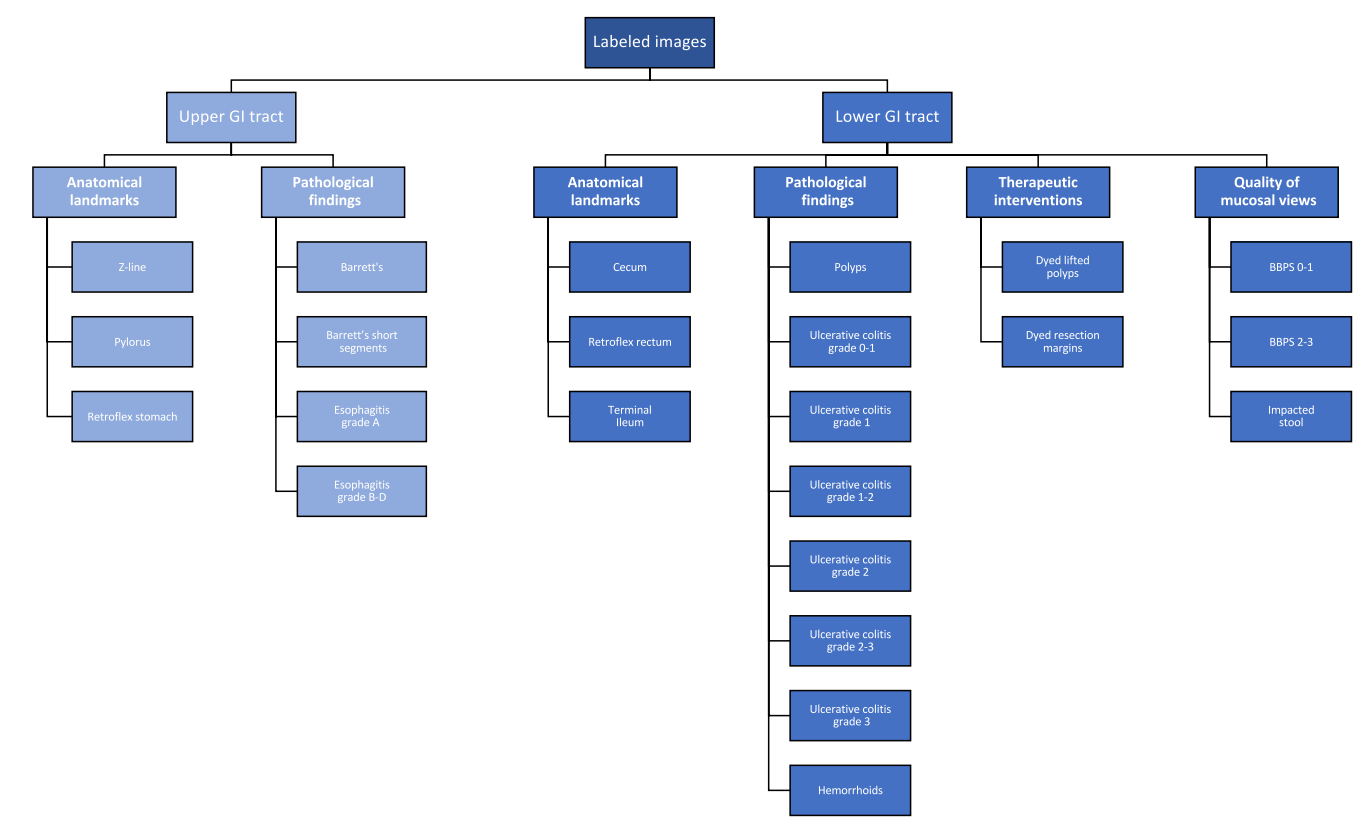

In [10]:
df_anno['Classification'].value_counts()

anatomical-landmarks         4104
pathological-findings        2642
therapeutic-interventions    1991
quality-of-mucosal-views     1925
Name: Classification, dtype: int64

In [11]:
df_pathologies = df_anno[((df_anno['Organ']=='upper-gi-tract') | (df_anno['Organ']=='lower-gi-tract')) & (df_anno['Classification']=='pathological-findings')]
df_pathologies = df_pathologies.reset_index()
# df_pathologies
df_others = df_anno[~(((df_anno['Organ']=='upper-gi-tract') | (df_anno['Organ']=='lower-gi-tract')) & (df_anno['Classification']=='pathological-findings'))]
df_others

,Organ,Classification,Finding,Image
1885,lower-gi-tract,therapeutic-interventions,dyed-lifted-polyps,lower-gi-tract/therapeutic-interventions/dyed-...
1886,lower-gi-tract,therapeutic-interventions,dyed-lifted-polyps,lower-gi-tract/therapeutic-interventions/dyed-...
1887,lower-gi-tract,therapeutic-interventions,dyed-lifted-polyps,lower-gi-tract/therapeutic-interventions/dyed-...
1888,lower-gi-tract,therapeutic-interventions,dyed-lifted-polyps,lower-gi-tract/therapeutic-interventions/dyed-...
1889,lower-gi-tract,therapeutic-interventions,dyed-lifted-polyps,lower-gi-tract/therapeutic-interventions/dyed-...
...,...,...,...,...
10657,upper-gi-tract,anatomical-landmarks,retroflex-stomach,upper-gi-tract/anatomical-landmarks/retroflex-...
10658,upper-gi-tract,anatomical-landmarks,retroflex-stomach,upper-gi-tract/anatomical-landmarks/retroflex-...
10659,upper-gi-tract,anatomical-landmarks,retroflex-stomach,upper-gi-tract/anatomical-landmarks/retroflex-...
10660,upper-gi-tract,anatomical-landmarks,retroflex-stomach,upper-gi-tract/anatomical-landmarks/retroflex-...


In [12]:
df_others['Classification'].value_counts()

anatomical-landmarks         4104
therapeutic-interventions    1991
quality-of-mucosal-views     1925
Name: Classification, dtype: int64

In [13]:
list_cat = list(set(df_pathologies['Finding']))
dict_cat = {}
for cat in list_cat:
    dict_cat[cat] = list_cat.index(cat)+1
df_pathologies['Categories'] = [dict_cat[item] for item in df_pathologies['Finding']]
df_pathologies

,index,Organ,Classification,Finding,Image,Categories
0,0,lower-gi-tract,pathological-findings,polyps,lower-gi-tract/pathological-findings/polyps/ec...,6
1,1,lower-gi-tract,pathological-findings,polyps,lower-gi-tract/pathological-findings/polyps/37...,6
2,2,lower-gi-tract,pathological-findings,polyps,lower-gi-tract/pathological-findings/polyps/28...,6
3,3,lower-gi-tract,pathological-findings,polyps,lower-gi-tract/pathological-findings/polyps/19...,6
4,4,lower-gi-tract,pathological-findings,polyps,lower-gi-tract/pathological-findings/polyps/61...,6
...,...,...,...,...,...,...
2637,7962,upper-gi-tract,pathological-findings,esophagitis-b-d,upper-gi-tract/pathological-findings/esophagit...,2
2638,7963,upper-gi-tract,pathological-findings,esophagitis-b-d,upper-gi-tract/pathological-findings/esophagit...,2
2639,7964,upper-gi-tract,pathological-findings,esophagitis-b-d,upper-gi-tract/pathological-findings/esophagit...,2
2640,7965,upper-gi-tract,pathological-findings,esophagitis-b-d,upper-gi-tract/pathological-findings/esophagit...,2


In [14]:
dict_cat

{'ulcerative-colitis-grade-2': 1,
 'esophagitis-b-d': 2,
 'ulcerative-colitis-grade-0-1': 3,
 'ulcerative-colitis-grade-2-3': 4,
 'ulcerative-colitis-grade-1-2': 5,
 'polyps': 6,
 'ulcerative-colitis-grade-3': 7,
 'ulcerative-colitis-grade-1': 8,
 'barretts-short-segment': 9,
 'hemorrhoids': 10,
 'barretts': 11,
 'esophagitis-a': 12}

In [15]:
df_pathologies['Categories'].value_counts()

6     1028
1      443
12     403
2      260
8      201
7      133
9       53
11      41
3       35
4       28
5       11
10       6
Name: Categories, dtype: int64

In [16]:
df_others['Categories'] = 0
df_full = pd.concat([df_pathologies, df_others], axis=0).reset_index()
df_full.pop('index');
df_full.pop('level_0');
df_full

/home/nguyentai/anaconda3/envs/cls/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Organ,Classification,Finding,Image,Categories
0,lower-gi-tract,pathological-findings,polyps,lower-gi-tract/pathological-findings/polyps/ec...,6
1,lower-gi-tract,pathological-findings,polyps,lower-gi-tract/pathological-findings/polyps/37...,6
2,lower-gi-tract,pathological-findings,polyps,lower-gi-tract/pathological-findings/polyps/28...,6
3,lower-gi-tract,pathological-findings,polyps,lower-gi-tract/pathological-findings/polyps/19...,6
4,lower-gi-tract,pathological-findings,polyps,lower-gi-tract/pathological-findings/polyps/61...,6
...,...,...,...,...,...
10657,upper-gi-tract,anatomical-landmarks,retroflex-stomach,upper-gi-tract/anatomical-landmarks/retroflex-...,0
10658,upper-gi-tract,anatomical-landmarks,retroflex-stomach,upper-gi-tract/anatomical-landmarks/retroflex-...,0
10659,upper-gi-tract,anatomical-landmarks,retroflex-stomach,upper-gi-tract/anatomical-landmarks/retroflex-...,0
10660,upper-gi-tract,anatomical-landmarks,retroflex-stomach,upper-gi-tract/anatomical-landmarks/retroflex-...,0


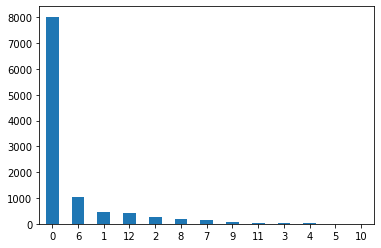

In [17]:
df_full['Categories'].value_counts().plot(kind='bar');
plt.xticks(rotation=0);

In [18]:
df_full['Categories'].value_counts()

0     8020
6     1028
1      443
12     403
2      260
8      201
7      133
9       53
11      41
3       35
4       28
5       11
10       6
Name: Categories, dtype: int64

In [19]:
df_train, df_valid = train_test_split(df_full, test_size=0.25, random_state=0)
df_train['is_valid'] = False
df_valid['is_valid'] = True
df_full = pd.concat([df_train, df_valid], axis=0)

/home/nguyentai/anaconda3/envs/cls/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/nguyentai/anaconda3/envs/cls/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
df_train['Categories'].value_counts()

0     5999
6      796
1      334
12     303
2      190
8      144
7       94
9       41
11      34
3       29
4       21
5        7
10       4
Name: Categories, dtype: int64

In [21]:
df_valid['Categories'].value_counts()

0     2021
6      232
1      109
12     100
2       70
8       57
7       39
9       12
11       7
4        7
3        6
5        4
10       2
Name: Categories, dtype: int64

In [22]:
# df_full.to_csv('../resource/hyper_kvasir/full_labeled_anno.csv',header=True, index=False)

## Image Deformation

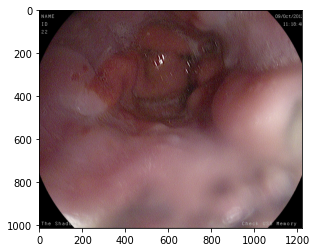

In [23]:
ex_img = cv2.imread(os.path.join(_HYPER_KVASIR, df_train['Image'].iloc[4000]))
ex_img = cv2.cvtColor(ex_img, cv2.COLOR_BGR2RGB)
plt.imshow(ex_img)

In [24]:
# /home/nguyentai/working/plt.imshow(resize_aspect_ratio(ex_img, size = 336))

In [25]:
# plt.imshow(deformation(ex_img))

In [26]:
"""
radius = 282.5;
[X,Y] = meshgrid([-radius:1:radius]/radius,[-radius:1:radius]/radius);
X = X(((radius+0.5)*2-512)/2+1:radius+256.5,((radius+0.5)*2-512)/2+1:radius+256.5);
Y = Y(((radius+0.5)*2-512)/2+1:radius+256.5,((radius+0.5)*2-512)/2+1:radius+256.5);
%[X,Y] = meshgrid([-255.5:1:255.5]/255.5,[-255.5:1:255.5]/255.5);
U = X .* sqrt(1-Y.^2/2.0);
V = Y .* sqrt(1-X.^2/2.0);
flow = zeros([512,512,2]);
flow(:,:,1) = (-X+U)*radius;
flow(:,:,2) = (-Y+V)*radius;
"""
def deformation(img):
    h, w = img.shape[:2]
    xcent = w / 2
    ycent = h / 2

    # set up the maps as float32 from output square (x,y) to input circle (u,v)
    map_u = np.zeros((h, w), np.float32)
    map_v = np.zeros((h, w), np.float32)

    # create u and v maps where x,y is measured from the center and scaled from -1 to 1
    for y in range(h):
        y_norm = (y - ycent)/ycent
        for x in range(w):
            x_norm = (x - xcent)/xcent
            map_u[y, x] = xcent * x_norm * np.sqrt(1 - 0.5*y_norm**2) + xcent
            map_v[y, x] = ycent * y_norm * np.sqrt(1 - 0.5*x_norm**2) + ycent
    img_deform = cv2.remap(img, map_u, map_v, cv2.INTER_LINEAR, borderMode = cv2.BORDER_REFLECT_101, borderValue=(0,0,0))
    return img_deform

In [27]:
# df_full['Image']

In [28]:
def single_process(img_path):
    img_path = os.path.join(_HYPER_KVASIR, img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = resize_aspect_ratio(img, size=336)
    img_deform = deformation(img)
    img_deform = cv2.cvtColor(img_deform, cv2.COLOR_RGB2BGR)
    dest_path = img_path.replace('labeled-images','labeled-images-deform')
    list_dest_dir = dest_path.split('/')
    for i in range(len(list_dest_dir)):
        dest_dir = '/'.join(list_dest_dir[:i])
        if dest_dir and not os.path.isdir(dest_dir):
            os.mkdir(dest_dir)
    cv2.imwrite(dest_path, img_deform)

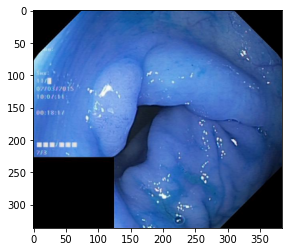

In [29]:
ex_img = cv2.imread(os.path.join(_HYPER_KVASIR,df_train['Image'].iloc[1999]))
ex_img = resize_aspect_ratio(ex_img, size=336)
plt.imshow(ex_img)

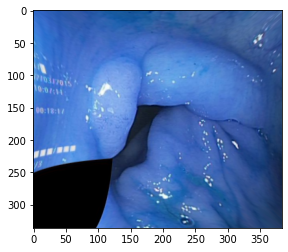

In [30]:
plt.imshow(deformation(ex_img))

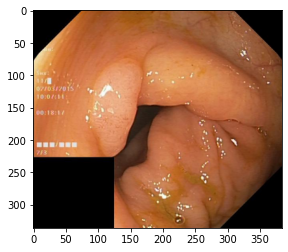

In [31]:


hh, ww = ex_img.shape[:2]
hh2 = hh // 2
ww2 = ww // 2

# define circles
radius = 440//2
yc = hh2
xc = ww2

mask = np.zeros_like(ex_img)
mask = cv2.circle(mask, (xc,yc), radius, (255,255,255), -1)
result = cv2.cvtColor(ex_img, cv2.COLOR_BGR2RGB)
# result[:, :, 3] = mask[:,:,0]
result = np.multiply(result, np.dstack([np.where(mask[:,:,0]==0, mask[:,:,0], 1)]*3))

plt.imshow(result)

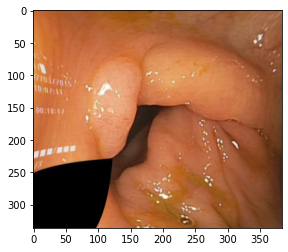

In [32]:
plt.imshow(deformation(result))

In [33]:
df_train['Image'].iloc[4000]

'upper-gi-tract/anatomical-landmarks/z-line/0f8d0452-78f0-4f1b-922c-ffdd56a57a4a.jpg'

In [34]:
# single_process(df_train['Image'].iloc[4000])

In [35]:
# ## multiprocess
# pool = mp.Pool(8)
# for _ in tqdm(pool.imap_unordered(single_process,list(df_full['Image'])), total = len(df_full)):
#     pass

## Unlabeled Images

In [48]:
_HYPER_KVASIR_UNL

'../../data/hyper_kvasir/unlabeled-images'

In [49]:
unl_imgs = glob(os.path.join(_HYPER_KVASIR_UNL,"*.jpg"))
len(unl_imgs)

99417

In [37]:
def crop_square(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape
    if w/h > 1.4:
#         print('Crop Square Processing...')
        _, thresh_original = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY)
        thresh = copy.copy(thresh_original)
#         plt.imshow(thresh)
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # get contours with highest height
        lst_contours = []
        for cnt in contours:
            ctr = cv2.boundingRect(cnt)
            lst_contours.append(ctr)
        x,y,w,h = sorted(lst_contours, key=lambda coef: coef[3])[-1]
        crop_img = img[y:y+h,x:x+w]
        return crop_img
    else:
        return img
    
def single_process_unl(img_path):
    img = cv2.imread(img_path)
    img = crop_square(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = resize_aspect_ratio(img, size=336)
    img_deform = deformation(img)
    img_deform = cv2.cvtColor(img_deform, cv2.COLOR_RGB2BGR)
    dest_path = img_path.replace('unlabeled-images','unlabeled-images-deform')
    list_dest_dir = dest_path.split('/')
    for i in range(len(list_dest_dir)):
        dest_dir = '/'.join(list_dest_dir[:i])
        if dest_dir and not os.path.isdir(dest_dir):
            os.mkdir(dest_dir)
    cv2.imwrite(dest_path, img_deform)

In [38]:
# unl_imgs

In [50]:
list_available = []
for img_path in tqdm(unl_imgs):
    try:
        if os.path.getsize(img_path) != 0:
            list_available.append(img_path)
    except Exception as e:
        print(e)
        continue

100%|██████████| 99417/99417 [00:00<00:00, 461201.42it/s]


In [40]:
len(list_available)

99417

In [42]:
# unl_imgs = glob(os.path.join('/home/nguyentai/working/data/hyper_kvasir/unlabeled-images-deform',"*.jpg"))
# len(unl_imgs)

99417

In [53]:
def show_grid(list_imgs):
    fig=plt.figure(figsize=(20,7))
    rows = 5
    columns = len(list_imgs)//rows
    k = 0
    for i in range(0, rows):
        for j in range(0, columns):
            img = cv2.imread(list_imgs[k])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            fig.add_subplot(rows, columns, k+1)
            plt.imshow(img)
            plt.axis('off')
            k += 1

True

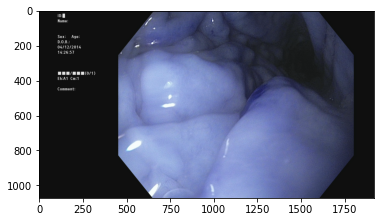

In [99]:
ex_img = cv2.imread(unl_imgs[10018])
# ex_img = cv2.cvtColor(ex_img, cv2.COLOR_BGR2RGB)
plt.imshow(ex_img)
cv2.imwrite('./sample_wide.jpg', ex_img)

In [100]:
gray = cv2.cvtColor(ex_img, cv2.COLOR_BGR2GRAY)
h, w = gray.shape
if w/h > 1.4:
#         print('Crop Square Processing...')
    _, thresh_original = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY)
    thresh = copy.copy(thresh_original)
#         plt.imshow(thresh)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # get contours with highest height
    lst_contours = []
    for cnt in contours:
        ctr = cv2.boundingRect(cnt)
        lst_contours.append(ctr)
    x,y,w,h = sorted(lst_contours, key=lambda coef: coef[3])[-1]
    crop_img = ex_img[y:y+h,x:x+w]
#     ex_img_rec = cv2.rectangle(ex_img, (x,y), (x+w,y+h), (10,255,255), 10)
#     plt.imshow(ex_img_rec)
#     cv2.imwrite('./sample_wide_detect.jpg', ex_img_rec)

True

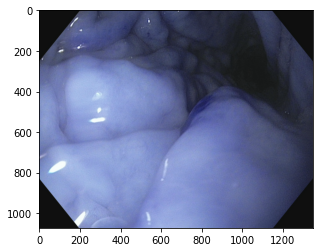

In [102]:
plt.imshow(crop_img)
cv2.imwrite('./sample_wide_crop.jpg', crop_img)

True

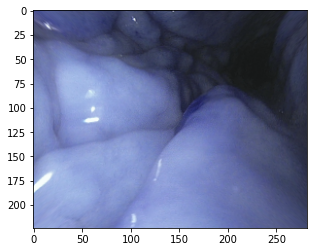

In [105]:
plt.imshow(deformation(resize_aspect_ratio(crop_img, size = 224)))
cv2.imwrite('./sample_wide_deform.jpg', deformation(resize_aspect_ratio(crop_img, size = 224)))

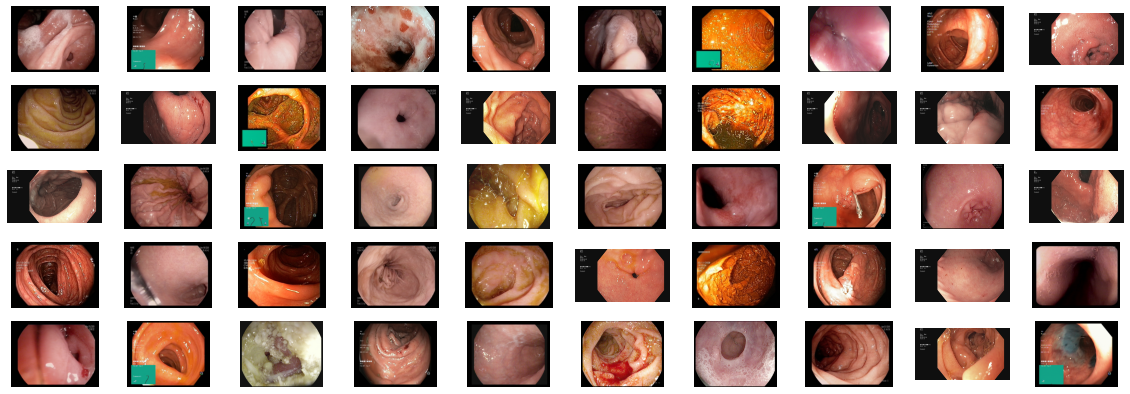

In [54]:
show_grid(unl_imgs[10000:10050])

In [45]:
# ## multiprocess
# pool = mp.Pool(8)
# for _ in tqdm(pool.imap_unordered(single_process_unl,list_available), total = len(list_available)):
#     pass